### Model development on a cloud workstation
This notebook contains just the code cells used in Tutorial: Model development on a cloud workstation. See the article for more details.

## Data Processing

In [26]:
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.classifier import ROCAUC


### Collect Data

In [ ]:
import pandas as pd

raw_data = r'.\data\processed\default_of_credit_card_clients.csv'
df = pd.read_csv(raw_data)


In [5]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [ ]:
# read in data again, this time using the 2nd row as the header
raw_data = r'.\data\processed\default_of_credit_card_clients.csv'
df = pd.read_csv(raw_data, header=1)
# rename column
df.rename(columns={"default payment next month": "default"}, inplace=True)
# remove ID column
df.drop("ID", inplace=True)

processed_data = r'.\data\processed\default_of_credit_card_clients.csv'
df.to_csv(processed_data)



### Missing Data

In [7]:
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

### Clean Data

In [13]:
#change header
df = pd.read_csv(raw_data, header=1)


In [14]:
df.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [15]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Feature Engineering

In [16]:
#Remove ID column
df.drop("ID", axis=1, inplace=True)

# rename column
df.rename(columns={"default payment next month": "default"}, inplace=True)

### Save the dataset

### Split the data

In [17]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [18]:
y = df.default
X = df.drop("default", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Pre Process Data

## Model development

### Create Base Model

In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
# Step 1:Create DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Step 2:Train the model
dummy_clf.fit(X_train, y_train)


# Step 3: Make predictions
preds = dummy_clf.predict(X_test)
acc = dummy_clf.score(X_test, y_test)


# Step 4: Evaluate the model
print(f"Predictions: {preds}")
print(f"Accuracy: {acc}")

# Predicted probabilities for the positive class
y_pred_prob = dummy_clf.predict_proba(X_test)[:, 1]

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score (DummyClassifier): {roc_auc:.2f}")



Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.7822222222222223
ROC AUC Score (DummyClassifier): 0.50


In [35]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
28465,240000,2,1,1,40,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
27622,50000,2,1,2,23,-1,-1,-1,-1,-1,...,2299,4800,9810,660,2548,2321,4800,9810,660,2980
28376,50000,2,2,1,36,2,2,2,2,0,...,49125,47956,43578,35126,0,4700,0,2004,3500,0
10917,200000,2,3,1,54,6,5,4,3,2,...,104686,102549,101400,0,0,0,0,0,0,0
27234,240000,1,1,1,35,-1,-1,-1,0,-1,...,21790,17102,13367,22659,2017,21817,1120,13434,22772,22820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,50000,1,2,2,32,0,0,0,0,0,...,55739,55957,29238,6119,2000,3000,1591,72,1134,73421
5390,200000,1,1,2,37,2,2,2,2,2,...,168386,164182,169029,172084,13500,6000,0,7500,6000,4000
860,50000,1,1,2,26,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
15795,70000,2,2,2,25,0,0,0,0,2,...,51152,35122,28633,28039,3000,2000,4500,1200,0,1200


### Create a model

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42 )
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluate

In [40]:
#validate model

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print("\n" "ROC AUC Score:", roc_auc_score(y_test, y_pred ))


Accuracy: 0.8133333333333334

ROC AUC Score: 0.6503985969387754


In [53]:
from sklearn import metrics
metrics.classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.84      0.94      0.89      7040\n           1       0.62      0.36      0.46      1960\n\n    accuracy                           0.81      9000\n   macro avg       0.73      0.65      0.67      9000\nweighted avg       0.79      0.81      0.79      9000\n'

#### Optimize model

In [42]:
rf4 = RandomForestClassifier()
params = {
    'n_estimators': [15, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [43]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rf4, params, cv=5)
cv.fit(X_train, y_train)


,estimator,RandomForestClassifier()
,param_grid,"{'class_weight': ['balanced', 'balanced_subsample'], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, ...], 'max_features': ['sqrt', 'log2'], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


#### Get the best model

In [44]:
print(cv.best_params_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}


In [45]:
best_params = cv.best_params_
rf5 = RandomForestClassifier(
    criterion=best_params['criterion'], 
    max_depth=best_params['max_depth'], 
    max_features=best_params['max_features'], 
    n_estimators=best_params['n_estimators'],
    class_weight=best_params['class_weight']
)

rf5.fit(X_train, y_train)

y_pred = rf5.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.771


### Evaluate the model

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7040
           1       0.48      0.59      0.53      1960

    accuracy                           0.77      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.77      0.78      9000



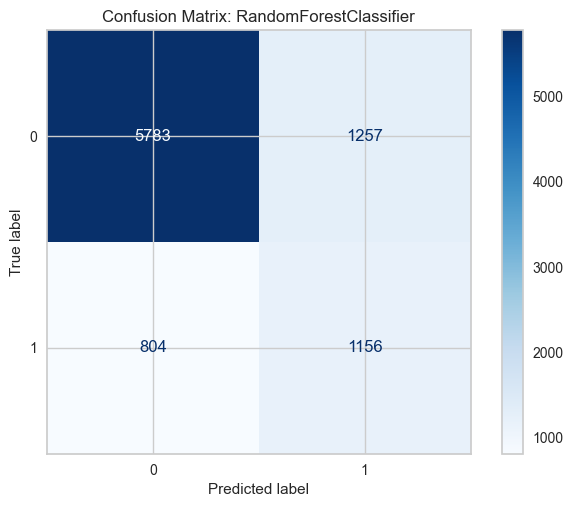


ROC AUC Score:

0.7056223910018553


C:\Users\flavi\git\ml-classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


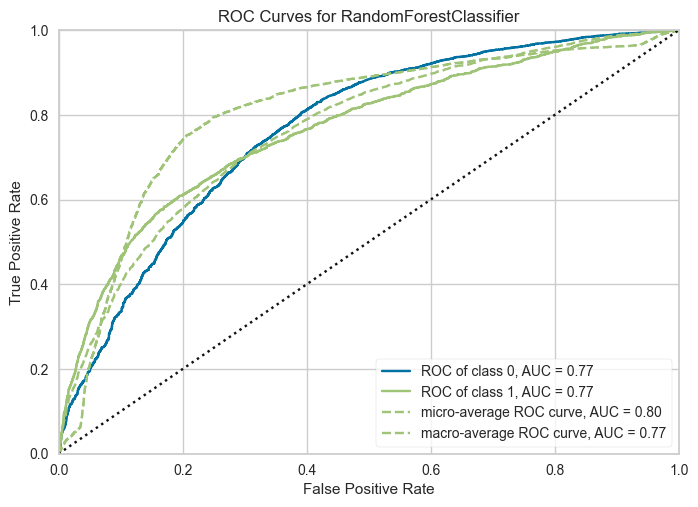

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

print("Classification Report:" "\n")
print(classification_report(y_test, y_pred))

# Get and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: RandomForestClassifier")
plt.show()
#
print("\n" "ROC AUC Score:" "\n")
print(roc_auc_score(y_test, y_pred ))

# Yellowbrick ROC AUC curve
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf5)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### Deploy the model

In [48]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rf5, open(filename, 'wb'))

In [49]:
# use the model
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

0.7056223910018553
